In [1]:
import epidag as dag
import complexism as cx

In [2]:
psc = """
    PCore pSIR {
        beta = 0.4
        gamma = 0.5
        Infect ~ exp(beta)
        Recov ~ exp(0.5)
        Die ~ exp(0.02)
    }
    """

dsc = """
CTBN SIR {
    life[Alive | Dead]
    sir[S | I | R]

    Alive{life:Alive}
    Dead{life:Dead}
    Inf{life:Alive, sir:I}
    Rec{life:Alive, sir:R}
    Sus{life:Alive, sir:S}

    Die -> Dead # from transition Die to state Dead by distribution Die
    Sus -- Infect -> Inf
    Inf -- Recov -> Rec

    Alive -- Die # from state Alive to transition Die
}
"""

bn = cx.read_pc(psc)
sm = dag.as_simulation_core(bn, hie={'city': ['agent'], 'agent': ['Recov', 'Die', 'Infect']})

In [3]:
pc = sm.generate()

dc = cx.read_dc(dsc)

Name = 'M1'
Gene = pc
proto = pc.breed('proto_agent_{}'.format('M1'), 'agent')
SS = dc.generate_model(Name, **pc.get_child_actors('agent'))

Three types of agents are supported by PyComplexism

- StSpAgent (State space agent): agents with states from state-space models
- DiffEqAgent (Differential equation agent): agents with inner dynamics from differential equations
- GenericAgent: agents allow fully customisation

In [4]:
Sus = SS['Sus']
tr = Sus.next_transitions()[1]
tr.rand()

3.4757352542397477

In [5]:
Sus.execute(cx.Event(tr, 1))

Inf

In [6]:
ag = cx.StSpAgent('Helen', SS['Sus'])
ag.initialise(0)
print(ag.Transitions)
print(ag.Next)

{Tr(Name: Infect, To: Inf, By: Infect (<scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000FAEDCF8>)): 1.0701149177667155, Tr(Name: Die, To: Dead, By: Die (<scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000FB056D8>)): 23.821830511374046}
Tr(Name: Infect, To: Inf, By: Infect (<scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000FAEDCF8>)): 1.0701149177667155


In [7]:
model = cx.SingleIndividualABM('M1', ag)


In [8]:
cx.simulate(model, None, 0, 10, 1)

,Name,State,Infect,Die
Time,,,,
0.0,Helen,Sus,NaN,NaN
1.0,Helen,Sus,NaN,NaN
2.0,Helen,Sus,NaN,NaN
3.0,Helen,Sus,NaN,NaN
4.0,Helen,Sus,NaN,NaN
5.0,Helen,Sus,NaN,NaN
6.0,Helen,Sus,NaN,NaN
7.0,Helen,Inf,1.0,NaN
8.0,Helen,Inf,NaN,NaN


In [1]:
from collections import Counter

In [3]:
dict(Counter([1,3,4]))

{1: 1, 3: 1, 4: 1}

In [30]:

sm1 = dag.as_simulation_core(bn)
sm1.deep_print()

None(Infect, Die, beta, gamma, Recov)


In [4]:
mc_bp = BlueprintABM('AB_abm', 'pAB', 'AB_mc')
mc_bp.set_observations(states=['N', 'A', 'B', 'AB'])
pc = pc_bp.get_simulation_model().sample_core()
dc = dc_bp.generate_model(pc=pc)

model = mc_bp.generate('A', pc=pc, dc=dc)
out = simulate(model, y0={'N': 500}, fr=0, to=10)
model.output(mid=False)

,N,A,B,AB
Time,,,,
0.0,500,0,0,0
1.0,459,2,29,10
2.0,411,4,54,31
3.0,362,14,72,52
4.0,325,16,76,83
5.0,292,22,63,123
6.0,269,20,56,155
7.0,241,20,56,183
8.0,223,22,45,210


In [5]:

par_script = """ 
PCore pSIR{
    transmission_rate = 1.5/200
    rec_rate ~ triangle(0.1, 0.2, 0.3)
    beta ~ exp(transmission_rate)
    gamma ~ exp(rec_rate)
    Die ~ exp(0.2)
}
"""

dc_ctbn_script = '''
CTBN SIR_BN {
    life[Alive | Dead]
    sir[S | I | R]
    
    Alive{life:Alive}
    Dead{life:Dead}
    Inf{life:Alive, sir:I}
    Rec{life:Alive, sir:R}
    Sus{life:Alive, sir:S}

    Die -> Dead # from transition Die to state Dead by distribution Die
    Sus -- Infect_Net(beta) -> Inf
    Sus -- Infect(beta) -> Inf 
    Inf -- Recov(gamma) -> Rec
    
    Alive -- Die # from state Alive to transition Die
}
'''

da = Director()
da.read_pc(par_script)
da.read_dc(dc_ctbn_script)

In [6]:
pc = da.get_pc('pSIR')
pc = pc.sample_core()
pc.Locus

{'rec_rate': 0.19268848936610913, 'transmission_rate': 0.0075}

In [7]:
cfd = da.new_mc('ABM_M2', 'ABM', tar_pc='pSIR', tar_dc='SIR_BN')
cfd.add_behaviour('cycle', be_type='Reincarnation', s_birth = 'Sus', s_death = 'Dead')
cfd.add_behaviour('foi', be_type='ComFDShock', s_src='Inf', t_tar = 'Infect', dt=0.5)
cfd.add_behaviour('step', be_type='TimeStep', ts=[0.5, 4], ys=[1, 0.1, 5], t_tar = 'Infect')

cfd.set_observations(states=['Sus', 'Inf', 'Rec'])

mod, out = da.simulate('ABM_M2', y0={'Sus': 95, 'Inf': 5}, fr=0 ,to=10, dt=.01)
out.plot()
plt.show()

TypeError: 'float' object is not callable

In [4]:
cfd = da.new_mc('ABM_M2', 'ABM', tar_pc='pSIR', tar_dc='SIR_BN')
cfd.add_network('IDU', 'BA', m=2)
cfd.add_behaviour('cycle', be_type='Reincarnation', s_birth = 'Sus', s_death = 'Dead')
cfd.add_behaviour('transmission', be_type='NetShock', s_src = 'Inf', t_tar = 'Infect_Net', net='IDU')
cfd.add_behaviour('foi', be_type='ForeignShock', t_tar = 'Infect')

cfd.set_observations(states=['Inf'], behaviours=['foi'])

cfd = da.new_mc('ABM_M5', 'ABM', tar_pc='pSIR', tar_dc='SIR_BN')
cfd.add_network('IDU', 'BA', m=5)
cfd.add_behaviour('cycle', be_type='Reincarnation', s_birth = 'Sus', s_death = 'Dead')
cfd.add_behaviour('transmission', be_type='NetShock', s_src = 'Inf', t_tar = 'Infect_Net', net='IDU')
cfd.add_behaviour('foi', be_type='ForeignShock', t_tar = 'Infect')

cfd.set_observations(states=['Inf'], behaviours=['foi'])

In [5]:
lyo = da.new_layout('Lyo1')

lyo.add_entry('A', 'ABM_M2', {'Sus': 20, 'Inf': 10})
lyo.add_entry('B', 'ABM_M2', {'Sus': 20}, size=3)
lyo.add_entry('C', 'ABM_M5', {'Sus': 20, 'Inf': 10}, size=2)
lyo.add_relation('*@Inf', 'Lyo1@FOI')
lyo.add_relation('Lyo1@FOI', '*@foi')
lyo.set_observations(['B_2', 'B_1', '*'])

dict_keys(['A', 'B_0', 'B_1', 'B_2', 'C_0', 'C_1'])
{'B_2', 'B_1'}


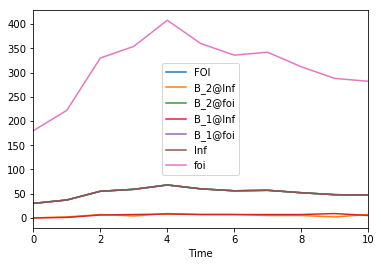

In [6]:
mod, out = da.simulate('Lyo1', fr=0, to=10)
out.plot()
plt.show()

In [4]:
pc, dc = generate_pc_dc(da.get_pc('pSIR'), da.get_dc('SIR_BN'))
mc = CoreODE(dc)
mc.Mods['FOI'] = InfectionFD('FOI', 'Infect', 'Inf')
mc.Mods['Dead'] = Reincarnation('Dead', s_death='Dead', s_birth='Sus')
model = ODEModel('SIR', mc, dt=0.01)
model.add_obs_transition('Infect')
model.add_obs_state('Alive')
model.add_obs_state('Inf')
model.add_obs_state('Sus')   
model.add_obs_behaviour('Dead')

In [18]:
cfd = da.new_mc('EBM', 'CoreODE', tar_pc='pSIR', tar_dc='SIR_BN')
cfd.add_behaviour('FOI', be_type='InfectionDD', s_src = 'Inf', t_tar = 'Infect')
cfd.add_behaviour('Dead', be_type='Reincarnation', s_death='Dead', s_birth='Sus')
cfd.set_arguments('dt', 0.5)
cfd.set_observations(states=['Sus', 'Inf', 'Rec', 'Alive'], behaviours=['FOI'])


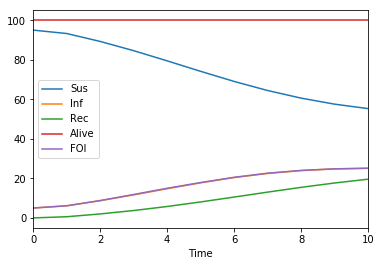

In [19]:
mod, out = da.simulate('EBM', y0={'Sus': 95, 'Inf': 5}, fr=0 ,to=10, dt=1)
#da.copy_model(mod_src=mod)
out.plot()
plt.show()

In [ ]:
out = simulate(model, y0={'Sus': 95, 'Inf': 5}, fr=0 ,to=10, dt=0.1)
out.plot()
plt.show()

In [11]:
mod.Obs.Obs